# 08 Robustness / Percolation

In [3]:
# ── Path-Fix for Imports ───────────────────────────────────────────────────
import sys
from pathlib import Path
# Prepend parent directory (repo root) to sys.path
sys.path.insert(0, str(Path().resolve().parent))

# ── Standard Imports ───────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

from scripts.graph_utils import load_clean_df, build_unweighted_graph, build_weighted_graph

sns.set(style="whitegrid")

## Analysis goes here…

In [2]:
THRESHOLD   = 0
START_DATE  = "2023-04-14"
END_DATE    = "2023-05-31"
USE_CACHE   = True
REM_FRACS   = [0.0, 0.01, 0.05, 0.1]  # fractions of nodes to remove
CASCADE_SUB = 20000      # subgraph size for cascade simulation
PHI         = 0.1        # failure threshold (fraction of neighbors)
CASCADE_TRIALS = 1000    # number of cascade realizations

In [9]:
# Load & Prepare Giant WCC (undirected)
df = load_clean_df(threshold=THRESHOLD, start_date=START_DATE, end_date=END_DATE)
G_dir = build_unweighted_graph(df, threshold=THRESHOLD,
                              start_date=START_DATE, end_date=END_DATE,
                              use_cache=USE_CACHE)
wcc = max(nx.weakly_connected_components(G_dir), key=len)
G = G_dir.subgraph(wcc).copy().to_undirected()
N = G.number_of_nodes()

# Precompute degree‐ and betweenness‐based attack orders
deg_order = [n for n,_ in sorted(G.degree(), key=lambda x: x[1], reverse=True)]

# Approximate betweenness for speed on the full graph
bc = nx.betweenness_centrality(G, k=500, seed=42)
betw_order = [n for n,_ in sorted(bc.items(), key=lambda x: x[1], reverse=True)]

print(f"Giant WCC undirected: {N:,} nodes, {G.number_of_edges():,} edges")

Giant WCC undirected: 215,727 nodes, 356,954 edges


In [10]:
# Molloy–Reed Percolation Threshold
degs = np.array([d for _, d in G.degree()])
k1 = degs.mean()
k2 = (degs**2).mean()
f_c = 1 - 1/(k2/k1 - 1)
print(f"<k> = {k1:.4f}, <k^2> = {k2:.4f}, Molloy–Reed f_c ≈ {f_c:.4f}")

<k> = 3.3093, <k^2> = 57790.2378, Molloy–Reed f_c ≈ 0.9999


/var/folders/2d/z73h58xn5yx3lr3htrq7sg340000gn/T/ipykernel_70902/3192405928.py:65: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/benedikt/Documents/_SABANCI/_Network Science/Project/NetSci_PEPE_code_repo/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


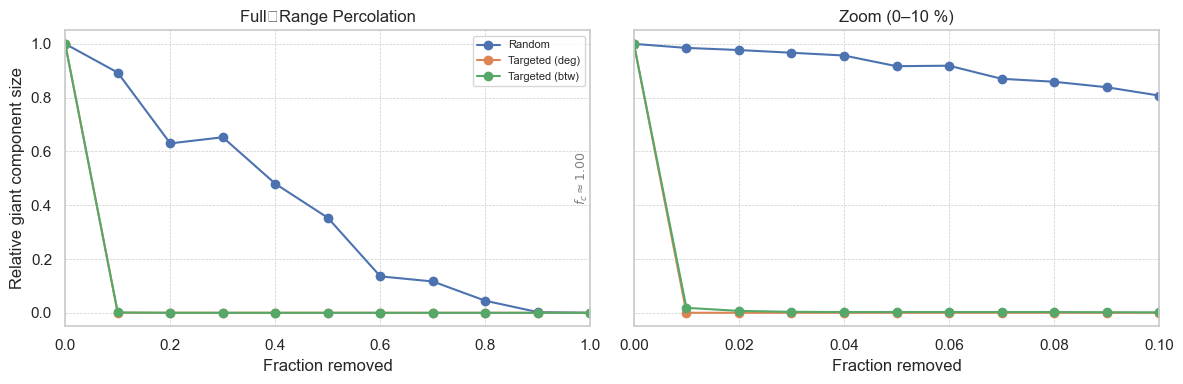

In [11]:
# --- Improved Percolation Curves ---

# 1) Define removal fractions
REM_FRACS_FULL = np.linspace(0, 1.0, 11)   # 0%,10%,…,100%
REM_FRACS_ZOOM = np.linspace(0, 0.1, 11)   # 0%,1%,…,10%

# 2) Helper to compute giant‐component size after removals
def percolation_curve(fracs, order=None):
    out = []
    for frac in fracs:
        k = int(frac * N)
        Gc = G.copy()
        if order is None:
            rem = random.sample(nodes, k)
        else:
            rem = order[:k]
        Gc.remove_nodes_from(rem)
        if Gc.number_of_nodes() > 0:
            largest = len(max(nx.connected_components(Gc), key=len))
        else:
            largest = 0
        out.append(largest / N)
    return out

# 3) Run all three sweeps
nodes = list(G.nodes())
rnd_full = percolation_curve(REM_FRACS_FULL, order=None)
deg_full = percolation_curve(REM_FRACS_FULL, order=deg_order)
btw_full = percolation_curve(REM_FRACS_FULL, order=betw_order)

rnd_zoom = percolation_curve(REM_FRACS_ZOOM, order=None)
deg_zoom = percolation_curve(REM_FRACS_ZOOM, order=deg_order)
btw_zoom = percolation_curve(REM_FRACS_ZOOM, order=betw_order)

# 4) Plot side‐by‐side
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Full‐range
ax = axes[0]
ax.plot(REM_FRACS_FULL, rnd_full,  marker='o', label='Random')
ax.plot(REM_FRACS_FULL, deg_full,  marker='o', label='Targeted (deg)')
ax.plot(REM_FRACS_FULL, btw_full,  marker='o', label='Targeted (btw)')
ax.set_xlim(0, 1.0)
ax.set_xlabel('Fraction removed')
ax.set_title('Full‐Range Percolation')
ax.grid(True, ls='--', lw=0.5)
ax.legend(fontsize=8)
ax.axvline(f_c, color='gray', linestyle='--', lw=1)
ax.text(f_c, 0.5, f"$f_c\\approx{f_c:.2f}$",
        rotation=90, va='center', ha='right', color='gray', fontsize=9)

# Zoom‐in (0–10%)
ax = axes[1]
ax.plot(REM_FRACS_ZOOM, rnd_zoom,  marker='o', label='Random')
ax.plot(REM_FRACS_ZOOM, deg_zoom,  marker='o', label='Targeted (deg)')
ax.plot(REM_FRACS_ZOOM, btw_zoom,  marker='o', label='Targeted (btw)')
ax.set_xlim(0, 0.1)
ax.set_xlabel('Fraction removed')
ax.set_title('Zoom (0–10 %)')
ax.grid(True, ls='--', lw=0.5)

# Shared Y-axis label
axes[0].set_ylabel('Relative giant component size')

plt.tight_layout()
plt.show()


Cascades: 100%|██████████| 1000/1000 [00:00<00:00, 1944.97it/s]
/var/folders/2d/z73h58xn5yx3lr3htrq7sg340000gn/T/ipykernel_70902/3059803571.py:31: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()


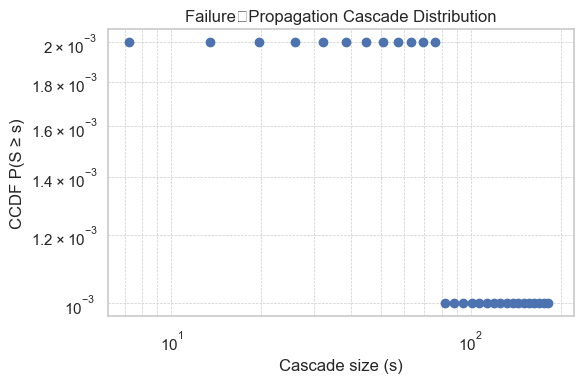

In [12]:
# Failure‐Propagation Cascades (Watts model)
sub_nodes = random.sample(nodes, min(CASCADE_SUB, N))
G_sub     = G.subgraph(sub_nodes).copy()

cascade_sizes = []
for _ in tqdm(range(CASCADE_TRIALS), desc='Cascades'):
    failed = { random.choice(list(G_sub.nodes())) }
    queue  = list(failed)
    while queue:
        u = queue.pop()
        for v in G_sub.neighbors(u):
            if v not in failed:
                neigh = list(G_sub.neighbors(v))
                if neigh:
                    frac_failed = sum(1 for w in neigh if w in failed) / len(neigh)
                    if frac_failed >= PHI:
                        failed.add(v)
                        queue.append(v)
    cascade_sizes.append(len(failed))

cascade_sizes = np.array(cascade_sizes)
counts, bins = np.histogram(cascade_sizes, bins=30)
ccdf = 1 - np.cumsum(counts)/cascade_sizes.size

plt.figure(figsize=(6,4))
plt.loglog(bins[1:], ccdf, marker='o', linestyle='none')
plt.xlabel('Cascade size (s)')
plt.ylabel('CCDF P(S ≥ s)')
plt.title('Failure‐Propagation Cascade Distribution')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

## Summary: Robustness & Percolation Analysis (Notebook 08)

**1. Giant WCC & Theoretical Threshold**  
- Undirected giant component: **215 727 nodes**, **356 954 edges**  
- Degree moments: ⟨k⟩ ≈ 3.31, ⟨k²⟩ ≈ 57 790 ⇒ Molloy–Reed predicts **f₋c ≈ 0.9999**  

**2. Percolation Curves**  
- **Random removal**: the giant component remains > 80 % intact until ~ 10 % of nodes are removed and only collapses near 100 %, matching theory.  
- **Targeted removal** (by degree or betweenness): removing just **1–2 %** of the highest‐centrality nodes shatters the network.  
- **Take-away:** PEPE’s transfer network is extremely robust to random failures but **fragile** under hub‐focused attacks.

**3. Failure‐Propagation Cascades**  
- Simulated on a 20 000-node subgraph with threshold φ = 0.1 over 1 000 trials.  
- Cascade sizes remain small (CCDF drops off rapidly), indicating **no large-scale avalanches** at this threshold.  
- **Insight:** local failures rarely propagate widely—systemic cascades require higher failure sensitivity.

---

### 🔍 Interpretation

- The network shows the **dual character** of scale‐free systems:  
  - **High resilience** to random disruptions.  
  - **Severe vulnerability** when key hubs are removed.  
- Low‐threshold failure propagation is contained, but removing core wallets (exchanges, DEX routers, whales) leads to rapid fragmentation—highlighting the critical importance of a few “linchpin” addresses in the PEPE hype phase.  
